In [1]:
import os
import numpy as np
import allel
import zarr
import pandas as pd
import gffutils
import tqdm

In [2]:
import os
import numpy as np
import allel
import zarr
import pandas as pd
import gffutils
import tqdm

In [3]:
os.chdir('/mnt/storage11/sophie/bijagos_mosq_wgs/2019_melas_fq2vcf_gambiae_aligned/genomics_database_melas2019plusglobal/genomics_database_melas2019plusglobal_vcf/melas_2019_plusglobal_filtering')
os.getcwd()

'/mnt/storage11/sophie/bijagos_mosq_wgs/2019_melas_fq2vcf_gambiae_aligned/genomics_database_melas2019plusglobal/genomics_database_melas2019plusglobal_vcf/melas_2019_plusglobal_filtering'

In [4]:
# convert phased, filtered, VCF file to zarr file
# already converted to zarr
#allel.vcf_to_zarr('2019melasglobal_finalfiltered_gambiaealigned_phased.vcf.gz', '2019melasglobal_finalfiltered_gambiaealigned_phased.zarr', fields='*', overwrite=True)

In [5]:
callset = zarr.open('2019melasglobal_finalfiltered_gambiaealigned_phased.zarr', mode='r')
#callset.tree(expand=True)

In [6]:
## convert zarr file to genotype array
gt = allel.GenotypeDaskArray(callset['calldata/GT'])
print(gt.shape)

(6767012, 37, 2)


In [7]:
## import metadata
df_samples=pd.read_csv('metadata_melasplusglobal.csv',sep=',',usecols=['sample','country','year','species','island'])
df_samples.head()
df_samples.groupby(by=['country']).count

<bound method GroupBy.count of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7f906c566170>>

In [8]:
## working with Guinea-Bissau samples

sample_ids = callset['samples'][:]
# Get sample identifiers for Cameroon samples from df_samples
gb_sample_ids = df_samples[df_samples['country'] == 'Guinea-Bissau']['sample'].values
# Find indices of these samples in the genotype array
gb_indices = np.array([np.where(sample_ids == id)[0][0] for id in gb_sample_ids if id in sample_ids])
# Verify the indices are within the correct range
print("Max index:", gb_indices.max(), "Sample array size:", len(sample_ids))
# Select genotypes for Cameroon samples using the indices
gt_gb_samples = gt.take(gb_indices, axis=1)
gt_gb_samples

Max index: 29 Sample array size: 37


<GenotypeDaskArray shape=(6767012, 30, 2) dtype=int8>

In [9]:
## select variants that are segregating within gb_samples as only these will be informative
## also some selection tests don't support multiallelic variants, so just keep biallelics
## for this pipeline the VCF is already filtered so should be no biallelic SNPs anyway

ac_gb = gt_gb_samples.count_alleles(max_allele=3).compute()
gb_seg_variants = ac_gb.is_segregating() & ac_gb.is_biallelic_01()
ac_gb_seg = ac_gb.compress(gb_seg_variants, axis=0)
gt_gb_seg = gt_gb_samples.compress(gb_seg_variants, axis = 0)
gt_gb_seg

<GenotypeDaskArray shape=(5673131, 30, 2) dtype=int8>

In [10]:
## this is from a phased VCF so we can convert this genotype array to haplotype array

h_gb_seg = gt_gb_seg.to_haplotypes().compute()
h_gb_seg

<HaplotypeArray shape=(5673131, 60) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 1 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 1 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [11]:
# we need variant positions
pos = callset['variants/POS'][:]
pos_gb_seg = pos.compress(gb_seg_variants, axis=0)
pos_gb_seg

array([  4221,   4234,   4239, ..., 184535, 184549, 184584], dtype=int32)

In [12]:
# some variants in 1000 genomes project have multiple variants at the same genomic position, 
# which causes problems for some selection tests in scikit-allel. 
# Let's check if there any of these.
count_multiple_variants = np.count_nonzero(np.diff(pos_gb_seg == 0))

if count_multiple_variants == 0:
    print("No cases where there are multiple variants at the same genomic position, script will continue")
else:
    print("There are multiple variants at the same genomic position. This causes problems with some selection tests using sci-kit allel.")
    #sys.exit()  # This will stop the script. If you want the script to continue anyway, # out this line

No cases where there are multiple variants at the same genomic position, script will continue


In [13]:
# compute raw iHS

ihs_gb_raw = allel.ihs(h_gb_seg, pos_gb_seg, use_threads=True, include_edges=True)
ihs_gb_raw
print("Raw iHS computed")

Raw iHS computed


In [14]:
#%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

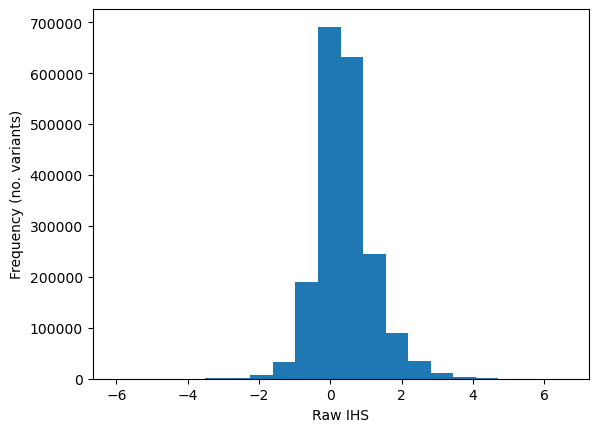

In [15]:
# ~np.isnan(ihs_gb_std[0]) is used to filter out NaN values
fig, ax = plt.subplots()
ax.hist(ihs_gb_raw[~np.isnan(ihs_gb_raw)], bins=20)
ax.set_xlabel('Raw IHS')
ax.set_ylabel('Frequency (no. variants)');

Standardized iHS computed


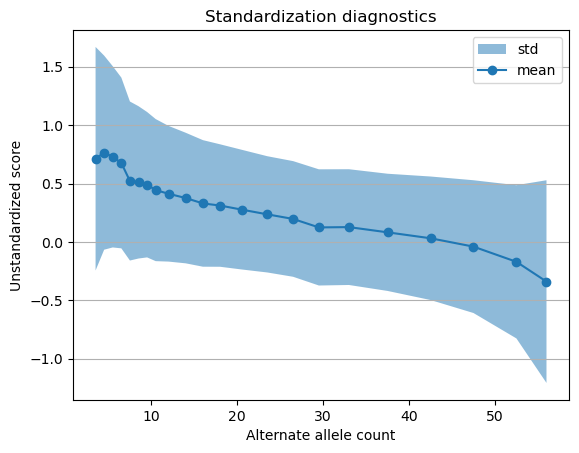

In [16]:
ihs_gb_std = allel.standardize_by_allele_count(ihs_gb_raw, ac_gb_seg[:, 1])
ihs_gb_std
print("Standardized iHS computed")

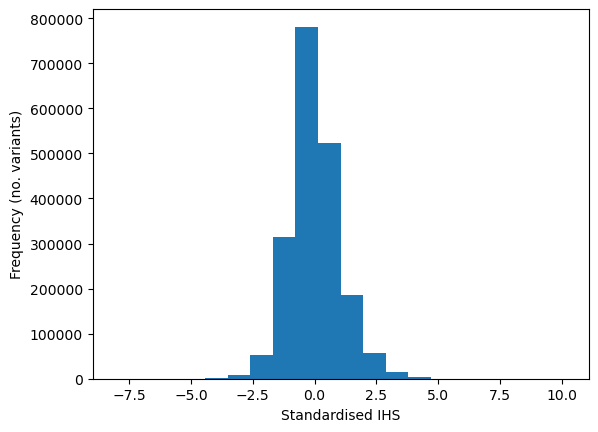

In [17]:
# Here we deviate from the Jupyter notebook and use ihs_res_std[0]
# ~np.isnan(ihs_gb_std[0]) is used to filter out NaN values
fig, ax = plt.subplots()
ax.hist(ihs_gb_std[0][~np.isnan(ihs_gb_std[0])], bins=20)
ax.set_xlabel('Standardised IHS')
ax.set_ylabel('Frequency (no. variants)');

# Save the figure as a file (e.g., PNG) in the current working directory
filename = f'standardised_ihs_histogram.png'
plt.savefig(filename)

# show the plot (optional, could # this out)
plt.show()

iHS plotted


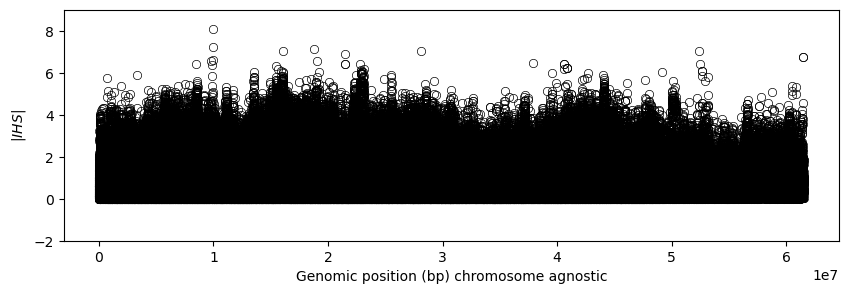

In [18]:
# is informative, not the sign.

# plot over the genome
# np.abs is converting all iHS vales to their absoltue values before plotting. This means that if ihs_gb_std[0]
# contains any negative valyes, those values will be made positive. It is plotting the magnitude of iHS without considering the
# direction of selection, which the sign of iHS could indicate

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(pos_gb_seg, np.abs(ihs_gb_std[0]), linestyle=' ', marker='o', mfc='none', mew=.5, mec='k')
ax.set_xlabel('Genomic position (bp) chromosome agnostic')
ax.set_ylabel('$|IHS|$')
ax.set_ylim(-2, 9);

# Save the figure as a file (e.g., PNG) in the current working directory
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'ihs_manhattan_{timestamp}.png'
plt.savefig(filename)

print("iHS plotted")

In [19]:
idx_hit_max = np.nanargmax(ihs_gb_std[0])

In [20]:
pos_gb_seg[idx_hit_max]
print(f'Genomic position with highest iHS value (chr agnostic):', pos_gb_seg[idx_hit_max])

Genomic position with highest iHS value (chr agnostic): 9932591


In [21]:
# pull out haplotypes for region around top hit
flank_size = 2000
h_hit = h_gb_seg[idx_hit_max - flank_size:idx_hit_max + flank_size + 1]
h_hit

<HaplotypeArray shape=(4001, 60) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 1 0 0
...
1 1 1 1 1 ... 1 1 0 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 1 0

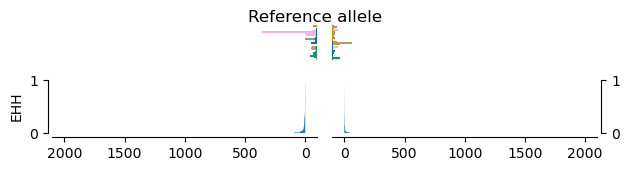

In [22]:
fig = allel.fig_voight_painting(h_hit[:, h_gb_seg[idx_hit_max] == 0], index=flank_size, height_factor=0.02)
fig.suptitle('Reference allele', y=1);

EHH decay computed


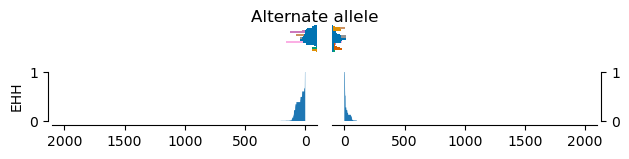

In [23]:
fig = allel.fig_voight_painting(h_hit[:, h_gb_seg[idx_hit_max] == 1], index=flank_size, height_factor=0.02)
fig.suptitle('Alternate allele', y=1);

print("EHH decay computed")

In [24]:
# length of gb_seg_variants = 6785669, it is a numpy.ndarray
chromosomes = callset['variants/CHROM'][:]
chrom_gb_seg = chromosomes.compress(gb_seg_variants, axis = 0)
chrom_gb_seg
# length of chrom_gb_seg = 5673213, it is a numpy.ndarray
pos = callset['variants/POS'][:]
pos_gb_seg = pos.compress(gb_seg_variants, axis=0)
pos_gb_seg
# length of pos_gb_seg = 5673213, it is a numpy.ndarray

# define chromosome lengths and colours 
chromosome_lengths = {
    '2L': 49364325,
    '2R': 61545105,
    '3L': 41963435,
    '3R': 53200684,
    'anop_mito': 15363,
    'anop_X': 24393108
}

#  Calculate cumulative offsets for each chromosome
cumulative_lengths = {}
cumulative_length = 0
for chrom, length in chromosome_lengths.items():
    cumulative_lengths[chrom] = cumulative_length
    cumulative_length += length

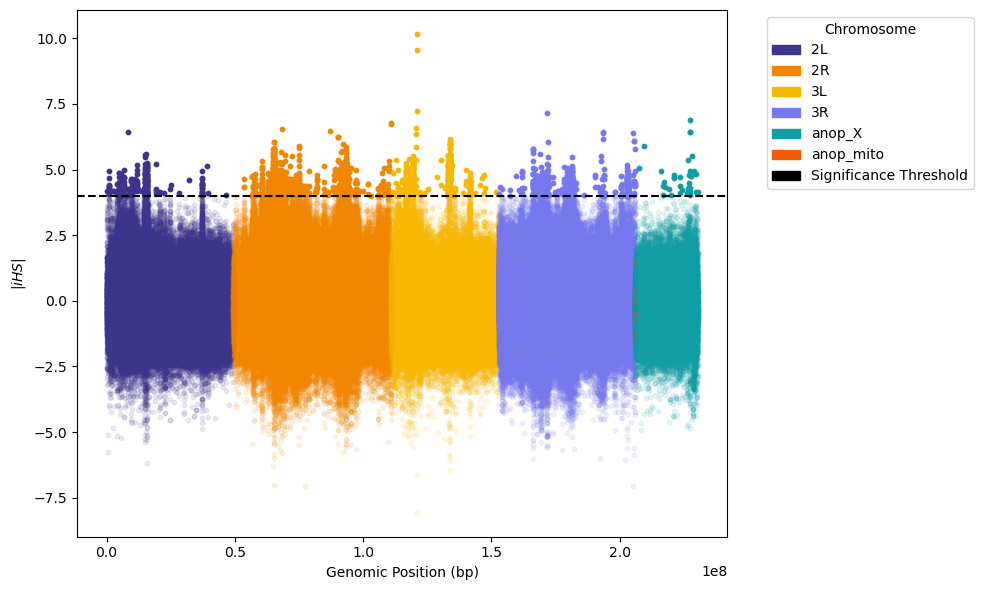

iHS plotted with all chromosomes


In [25]:
# `pos`, `chromosomes`, and `ihs_gb_std[0]` arrays are already defined and aligned
# Define the threshold
import matplotlib.patches as mpatches

threshold = 4

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each chromosome (for illustration)
chromosome_colours = {
    '2L': '#3d348b', '2R': '#f18701', '3L': '#f7b801', '3R': '#7678ed', 'anop_mito': '#f35b04', 'anop_X': '#119DA4'
}

# Create a list to hold the legend patches
legend_patches=[]

# Filter out 'Y_unplaced' or any other chromosomes not in your chromosome_lengths dictionary
filtered_chroms = [chrom for chrom in sorted(set(chrom_gb_seg)) if chrom in chromosome_lengths]

# Iterate through each chromosome to plot its variants
for chrom in filtered_chroms:
    # Create mask for the current chromosome
    mask = chrom_gb_seg == chrom
    
    # Apply the chromosome mask and filter out NaN values simultaneously
    chrom_positions = pos_gb_seg[mask]
    chrom_ihs_values = ihs_gb_std[0][mask]
    non_nan_mask = ~np.isnan(chrom_ihs_values)
    
    # Make sure to apply the non-NaN mask to both the positions and iHS values
    chrom_positions_no_nan = chrom_positions[non_nan_mask]
    chrom_ihs_values_no_nan = chrom_ihs_values[non_nan_mask]
    
    # Adjust positions for visualization if needed
    adjusted_positions = chrom_positions_no_nan + cumulative_lengths[chrom]

    # Now create threshold masks based on the non-NaN iHS values
    below_threshold_mask = chrom_ihs_values_no_nan < threshold
    above_threshold_mask = chrom_ihs_values_no_nan >= threshold
    
    # Plot points below and above the threshold
    ax.scatter(adjusted_positions[below_threshold_mask], 
               chrom_ihs_values_no_nan[below_threshold_mask], 
               color=chromosome_colours[chrom], alpha=0.1, s=10)
    ax.scatter(adjusted_positions[above_threshold_mask], 
               chrom_ihs_values_no_nan[above_threshold_mask], 
               color=chromosome_colours[chrom], alpha=1.0, s=10)
    patch = mpatches.Patch(color=chromosome_colours[chrom], label=chrom)
    legend_patches.append(patch)

legend_patches.append(mpatches.Patch(color='black', label='Significance Threshold'))
ax.legend(handles=legend_patches, title='Chromosome', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel('Genomic Position (bp)')
ax.set_ylabel('$|iHS|$')
ax.axhline(y=threshold, color='black', linestyle='--')
plt.tight_layout()
plt.show()

print("iHS plotted with all chromosomes")

In [26]:
ihs_vals = ihs_gb_std[0] # the standardised ihs values are saved in ihs_gb_std[0]
mask_non_nan = ~np.isnan(ihs_vals) #remove the ihs_gb_std nan values
ihs_vals_withoutnan = ihs_vals[mask_non_nan] # save these values as vals_withoutnan
pos_withoutnan = pos_gb_seg[mask_non_nan] # use the same mask to get the corresponding positions of vals_withoutnan
chrom_withoutnan = chrom_gb_seg[mask_non_nan] # use the same mask to get the corresponding chromosomes of vals_withoutnan
print("Filtered out NaN values")

Filtered out NaN values


In [27]:
sorted_indices = np.argsort(ihs_vals_withoutnan) # np.argsort returns an array of teh corresponding indices
sorted_ihs = np.sort(ihs_vals_withoutnan) 
print("Put values into ascending order")

Put values into ascending order


In [28]:
def calculate_empirical_p_value(val, sorted_vals,l):
    """
    Calculate the empirical p-value for an observed value in a sorted list of values.

    Parameters:
    - sorted_values: A list of values, sorted in ascending order.
    - observed_value: The observed value for which to calculate the p-value.
    - l: The length of the list of values

    Returns:
    - The empirical p-value.
    """
    return (l-np.where(sorted_vals>=val)[0][0])/l

In [29]:
print("Starting to calculate p-values of iHS")

# Multithread the p-value calculation because otherwise it is mega slow
import joblib
import tqdm

len_ihs = len(sorted_ihs)
pvals = []
from joblib import Parallel, delayed

parallel = Parallel(n_jobs=15, return_as='generator')
pvals = [r for r in tqdm.tqdm(parallel(delayed(calculate_empirical_p_value)(val,sorted_ihs,len_ihs) for val in sorted_ihs),total=len(sorted_ihs))]

Starting to calculate p-values of iHS


100%|██████████| 1942682/1942682 [02:46<00:00, 11670.59it/s]


In [30]:
# based on the position of the original ihs value in ihs_vals_withoutnan array

reordered_pvals = np.empty(len(pvals))
reordered_pvals[sorted_indices] = pvals # reordered_pvals will now have the p-values in the original order of the ihs values

In [31]:
neg_log_pvals = (-1*(np.log10(reordered_pvals)))
print("Computed log10 of p-values")

Computed log10 of p-values


Plotting neg log10 of p-values


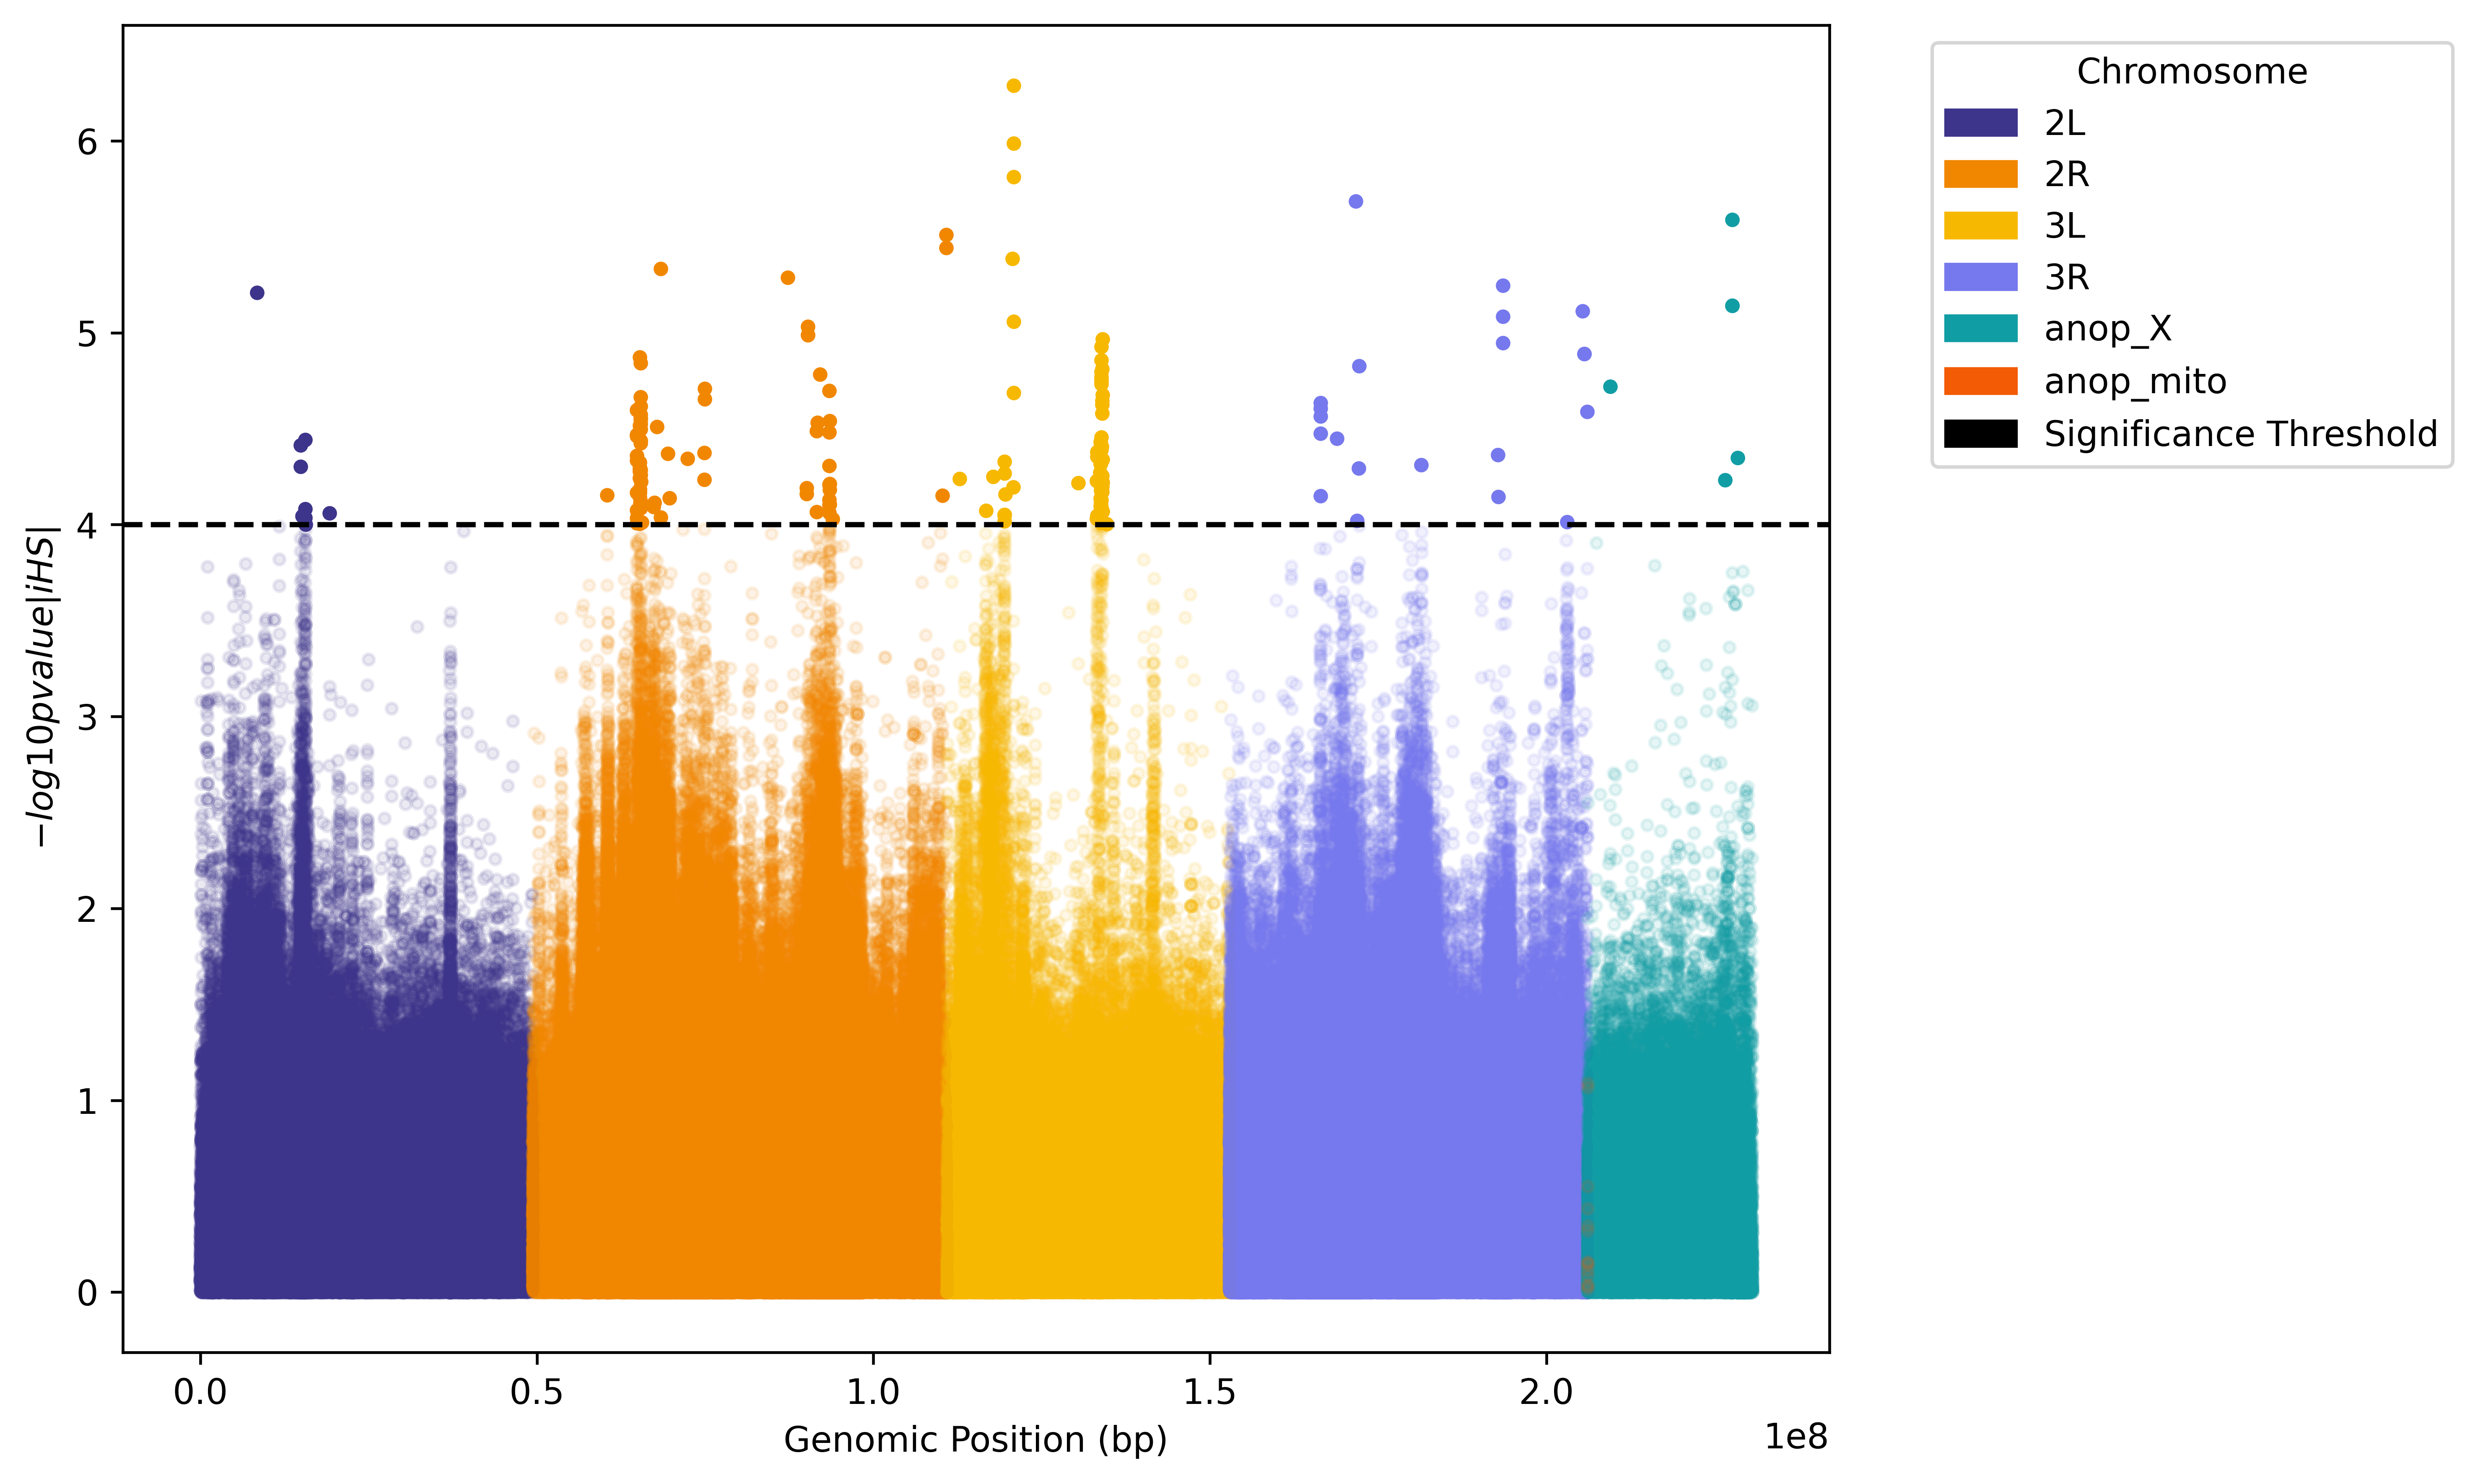

iHS p-values plotted with all chromosomes
iHS p-values above threshold identified


In [32]:
print("Plotting neg log10 of p-values")

# Define colors for each chromosome (for illustration)
chromosome_colours = {
    '2L': '#3d348b', '2R': '#f18701', '3L': '#f7b801', '3R': '#7678ed', 'anop_mito': '#f35b04', 'anop_X': '#119DA4'
}

# Plotting
threshold = 4

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=600)

# Define colors for each chromosome (for illustration)
chromosome_colours = {
    '2L': '#3d348b', '2R': '#f18701', '3L': '#f7b801', '3R': '#7678ed', 'anop_mito': '#f35b04', 'anop_X': '#119DA4'
}

# Create a list to hold the legend patches
legend_patches=[]

# Filter out 'Y_unplaced' or any other chromosomes not in your chromosome_lengths dictionary
filtered_chroms = ['2L', '2R', '3L', '3R', 'anop_X', 'anop_mito']

# Iterate through each chromosome to plot its variants
for chrom in filtered_chroms:
    # Create mask for the current chromosome
    mask = chrom_withoutnan == chrom
    
    # Apply the chromosome mask
    chrom_positions = pos_withoutnan[mask]
    chrom_p_values = neg_log_pvals[mask]
    
    # Adjust positions for visualization if needed
    adjusted_positions = chrom_positions + cumulative_lengths[chrom]

    # Now create threshold masks based on the non-NaN iHS values
    below_threshold_mask = chrom_p_values < threshold
    above_threshold_mask = chrom_p_values >= threshold
    
    # Plot points below and above the threshold
    ax.scatter(adjusted_positions[below_threshold_mask], 
               chrom_p_values[below_threshold_mask], 
               color=chromosome_colours[chrom], alpha=0.1, s=10)
    ax.scatter(adjusted_positions[above_threshold_mask], 
               chrom_p_values[above_threshold_mask], 
               color=chromosome_colours[chrom], alpha=1.0, s=10)
    patch = mpatches.Patch(color=chromosome_colours[chrom], label=chrom)
    legend_patches.append(patch)

legend_patches.append(mpatches.Patch(color='black', label='Significance Threshold'))
ax.legend(handles=legend_patches, title='Chromosome', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel('Genomic Position (bp)')
ax.set_ylabel('$- log10 pvalue |iHS|$')
ax.axhline(y=threshold, color='black', linestyle='--')
plt.tight_layout()
plt.savefig('ihs_pvalues_plot_600dpi.png')
plt.show()

print("iHS p-values plotted with all chromosomes")

## %% list all positions with iHS value over certain threshold

mask_pvalues_above_threshold = neg_log_pvals >= threshold
significant_ihs_positions = pos_withoutnan[mask_pvalues_above_threshold]
significant_ihs_chromosomes = chrom_withoutnan[mask_pvalues_above_threshold]
significant_ihs_values = neg_log_pvals[mask_pvalues_above_threshold]

print("iHS p-values above threshold identified")

## Save positions and corresponding iHS values above the threshold to a text file

with open(f"GuineaBissau_significant_iHS_threshold_{threshold}.txt", "w") as file:
    for chrom, position, ihs_value in zip(significant_ihs_chromosomes, significant_ihs_positions, significant_ihs_values):
        file.write(f"{chrom}\t{position}\t{ihs_value}\n")

In [33]:
print("Using GFF file to bring in annotations for these positions")

# Parameters
input_file_name = f"GuineaBissau_significant_iHS_threshold_{threshold}.txt"
output_file_name = f"GuineaBissau_significant_iHS_threshold_{threshold}_GFF_annotated.txt"
gff_file = '/mnt/storage11/sophie/reference_genomes/A_gam_P4_ensembl/Anopheles_gambiae.AgamP4.56.chr.gff3'

# Function to find and format the GFF line(s) that overlap a given position
def find_overlapping_gff_lines(chromosome, position, gff_file):
    overlapping_lines = []
    with open(gff_file, 'r') as gff:
        for line in gff:
            if line.startswith('#') or line.strip() == "":
                continue  # Skip header and empty lines
            parts = line.split('\t')
            if parts[0] == chromosome and int(parts[3]) <= position <= int(parts[4]):
                formatted_line = ",".join(parts).strip()
                overlapping_lines.append(formatted_line)
    return overlapping_lines

# Open the output file to write the annotated positions
with open(output_file_name, "w") as outfile:
    # Write the header line
    outfile.write("Chromosome\tPosition\tiHS Value\tGff_Annotation\n")

    # Open the file containing significant iHS positions to read
    with open(input_file_name, "r") as infile:
        for line in infile:
            parts = line.strip().split("\t")
            chromosome, position, ihs_value = parts[0], int(parts[1]), parts[2]
            
            # Find overlapping GFF lines for the position
            overlapping_gff_lines = find_overlapping_gff_lines(chromosome, position, gff_file)
            
            # Join all overlapping GFF lines into a single string
            gff_annotation = "; ".join(overlapping_gff_lines)
            
            # Write to the output file
            outfile.write(f"{chromosome}\t{position}\t{ihs_value}\t{gff_annotation}\n")

print(f"iHS significant values identified and GFF annotations written here: {output_file_name}")

Using GFF file to bring in annotations for these positions
iHS significant values identified and GFF annotations written here: GuineaBissau_significant_iHS_threshold_4_GFF_annotated.txt
